In [2]:
#!/usr/bin/env python
"""
--------------------------------------------------------------------------
Created June 20, 2023 for TRIPs-Py library
"""
__author__ = "Mirjeta Pasha and Connor Sanderford"
__copyright__ = "Copyright 2022, TRIPs-Py library"
__license__ = "GPL"
__version__ = "0.1"
__maintainer__ = "Mirjeta Pasha"
__email__ = "mirjeta.pasha@tufts.edu; mirjeta.pasha1@gmail.com"
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power
from numpy import array, diag, dot, maximum, empty, repeat, ones, sum
from numpy.linalg import inv
from trips.operators import *
##Specify the font
##Latex needs to be installed! If not installed, please comment the following 5 lines
parameters = {'xtick.labelsize': 12, 'ytick.labelsize': 12,
          'axes.titlesize': 18, 'axes.labelsize': 18, 'figure.titlesize': 14, 'legend.fontsize': 13}
plt.rcParams.update(parameters)
import time
import numpy as np
import scipy as sp
import scipy.stats as sps
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import astra
# import phantoms as phantom
from venv import create
import pylops
from scipy.ndimage import convolve
from scipy import sparse
from scipy.ndimage import convolve
import scipy.special as spe
from trips.testProblems import *
from trips.solvers.gks import *
import requests
from scipy import sparse
import numpy as np
import h5py
# functions to generate emoji data are stored in io_l.py
from trips.io import *
from trips.operators import *
from trips.solvers.AnisoTV import *
from trips.helpers import *

# Notebook 1: CrossPhantom test problem

<p>In this example we illustrate the following:
<p>&nbsp; Step 1: Download/read the crossPhantom data and prepare them for processing.
<p>&nbsp; Step 2: Solve the static inverse problem.
<p>&nbsp; Step 3: Solve the dynamic inverse problem.

CrossPhantom data are generated at the University of Helsinki: https://zenodo.org/record/1341457

#### Step 1: Download/read the data and prepare them for processing
##### The main function to generate the emoji data is generate_crossPhantom(dataset, noise_level) 
<p> <b>Input:</b> 
<p>&nbsp; <b>dataset:</b>
        <p>&nbsp; if dataset = 15, we generate data from DataDynamic_128x15.mat
        <p>&nbsp; if dataset = 60, we generate data from DataDynamic_128x60.mat
<p>&nbsp; <b>noise_level:</b>
        <p>&nbsp; CrossPhantom data are real data and they have noise. Hence, we set noise_level = 0
            
<p> <b>Output:</b>  
&nbsp;<br> <b>A:</b> The full forward operator for all time instances<br>
&nbsp; <b>b:</b> All the data/measurements vectorized<br> 
&nbsp; <b>AA:</b> A list of 16 time-wise operators<br> 
&nbsp; <b>B:</b> A list of 16 data vectors for each time instance <br> 
&nbsp; <b>nx:</b> The dimension of the first spatial domain<br> 
&nbsp; <b>ny:</b> The dimension of the second spatial domain<br> 
&nbsp; <b>nt:</b> The dimension of the time instances domain<br> 
&nbsp; <b>delta:</b> The noise level in the data. When we set noise_level == 0, we get delta = 0<br> 
&nbsp; <b>sinoshape:</b> The dimension of the time-wise sinogram<br>     

In [3]:
(A, b, AA, B, nx, ny, nt, delta) = generate_crossPhantom(noise_level = 0, dataset = 15)

Data already downloaded.


#### Step 2: Solve the static inverse problems.
<p>&nbsp; <b>The function to perform reconstruction is reconstruct_anisoTV(dynamic)</b>
<p> <b>Input:</b> 
<p>&nbsp; <b>dynamic:</b>
        <p>&nbsp; if dynamic = True, it solves the dynamic inverse problem $A x = b$
        <p>&nbsp; if dynamic = False, it solves nt static inverse problems $AA(i) x(i) = B(i)$, for i in range(nt)
<p> <b>Output:</b>  
&nbsp;<br> <b>xx:</b> <br>If dynamic == True, xx is a 3 dimensional tensor with dimensions (nx, ny, nt) that contains nt reconstructed images<br>If dynamic == False, xx is a list with nt elements that contains nt reconstructed images

In [4]:
xx = AnisoTV(A, b, AA, B, nx, ny, nt, dynamic = False, iters = 2, testproblem = 'CrossPhantom')

generating basis...:   0%|          | 0/3 [00:00<?, ?it/s]

running MMGKS...: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]


<Figure size 432x288 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

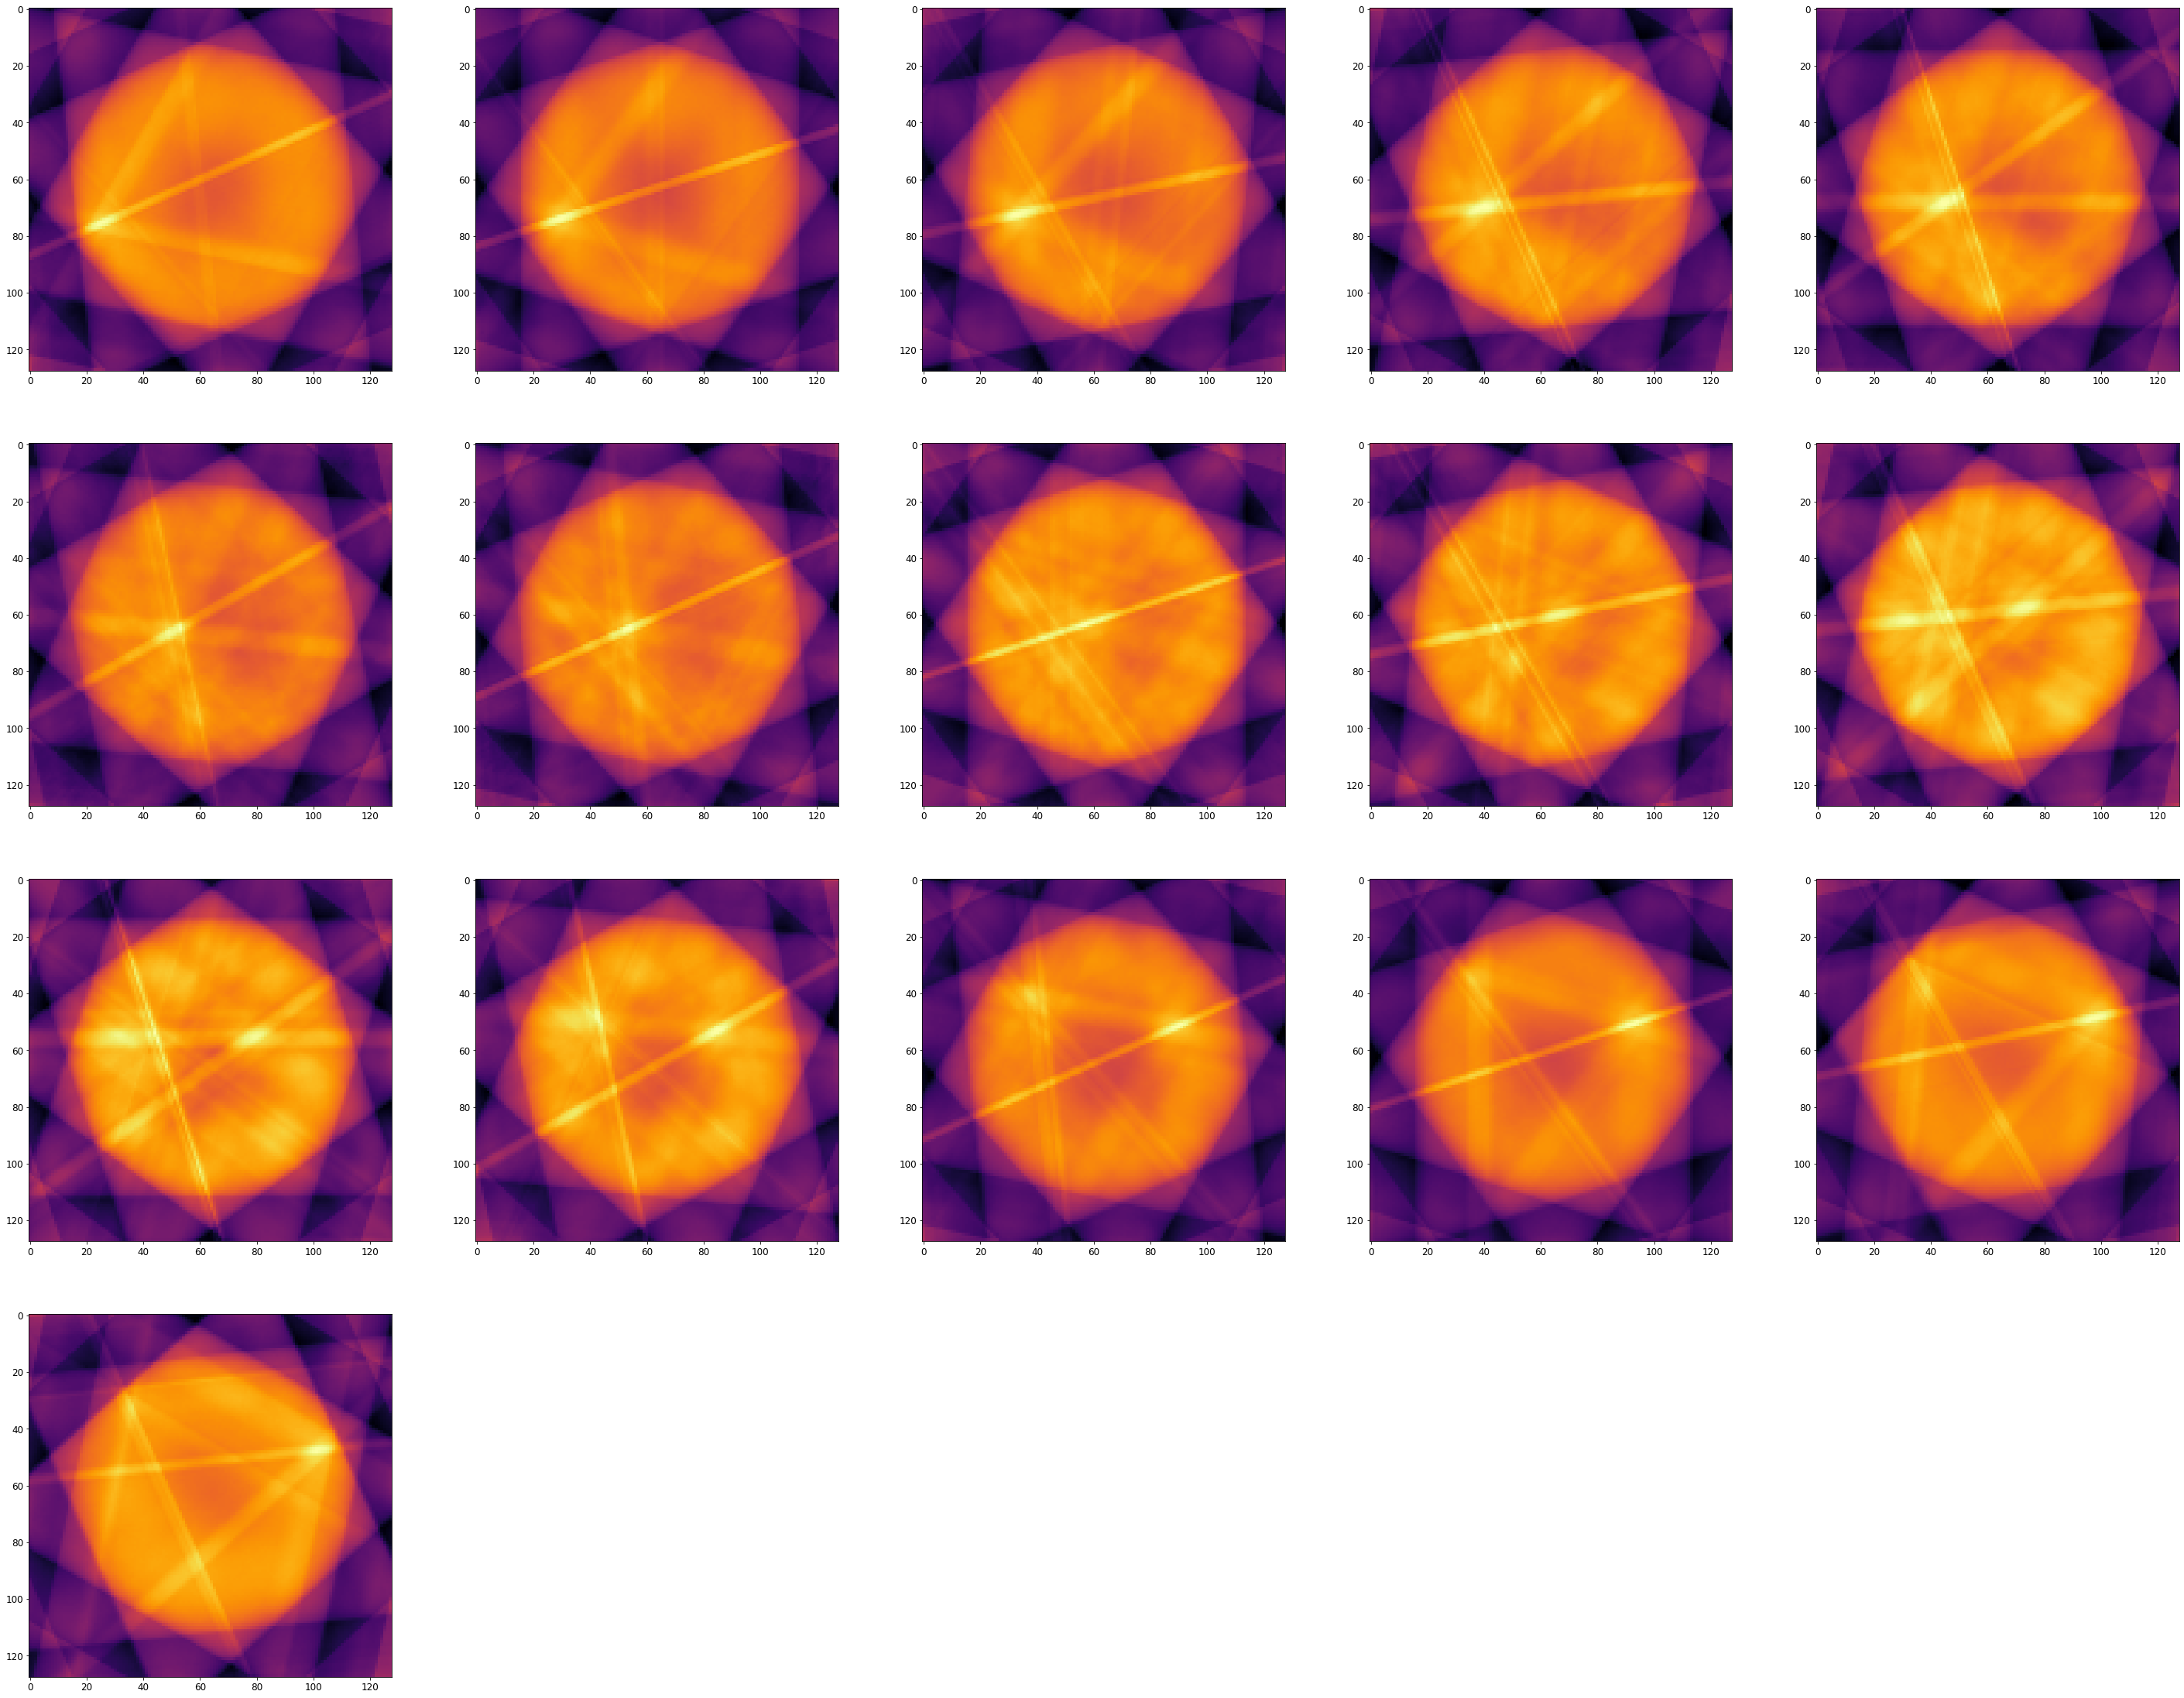

In [13]:
plot_recstructions_series(xx, (nx, ny, nt), dynamic = False, testproblem = 'crossPhantom', geome_x = 1,geome_x_small = 0,  save_imgs= False, save_path='./reconstruction/CrossPhantom')

#### Step 3: Solve dynamic inverse problems.
<p>&nbsp; <b>The function to perform reconstruction is reconstruct_anisoTV(dynamic)</b>
<p> <b>Input:</b> 
<p>&nbsp; <b>dynamic:</b>
        <p>&nbsp; if dynamic = True, it solves the dynamic inverse problem $A x = b$
        <p>&nbsp; if dynamic = False, it solves nt static inverse problems $AA(i) x(i) = B(i)$, for i in range(nt)
<p> <b>Output:</b>  
&nbsp;<br> <b>xx:</b> <br>If dynamic == True, xx is a 3 dimensional tensor with dimensions (nx, ny, nt) that contains nt reconstructed images<br>If dynamic == False, xx is a list with nt elements that contains nt reconstructed images

In [12]:
xx = AnisoTV(A, b, AA, B, nx, ny, nt, dynamic = True, iters = 5, testproblem = 'CrossPhantom')

running MMGKS...: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]


In [16]:
xx.shape

(128, 128, 16)

In [14]:
plt.imshow(xx[1].reshape((nx, ny)))

ValueError: cannot reshape array of size 2048 into shape (128,128)

TypeError: list indices must be integers or slices, not tuple

<Figure size 432x288 with 0 Axes>

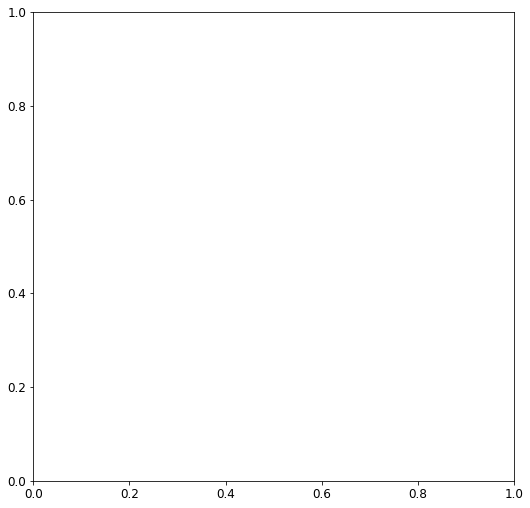

In [6]:
plot_recstructions_series(xx, (nx, ny, nt), dynamic = True, testproblem = 'CrossPhantom', geome_x = 1,geome_x_small = 0,  save_imgs= False, save_path='./reconstruction/CrossPhantom')

#### Step 4: Solve the problem by Golub-Kahan

generating basis...:   0%|          | 0/30 [00:00<?, ?it/s]

generating basis...: 100%|██████████| 30/30 [00:03<00:00,  8.09it/s]


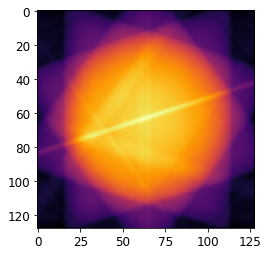

In [21]:
b_vec = b.reshape((-1,1))
projection_dim = 30
(U, B, V) = generalized_golub_kahan(A, b_vec, projection_dim)
VV = V
UU = U[:, 0:-1]
HH = B[0:-1, :]
bhat = UU.T.dot(b_vec)
y_tikh = np.linalg.solve(HH.T*HH, bhat)
x_GKahan = VV.dot(y_tikh)
xx = np.reshape(x_GKahan, (nt, nx, ny))
xx.shape
plt.imshow(xx[1, :, :])